## Grain size distributions from the Lab
### Actual Samples
> Here I will read the GS curves that are coming back from the lab

Hateren 2018 in sedimentary geology


In [1]:
#%load_ext nb_black

In [2]:
# install packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob as glob

    
from matplotlib.pyplot import cm

import composition_stats as comp

## import custom functions
from transformations import simplex_2_real, rplus_2_real

In [3]:
pd.set_option('display.max_rows', 15) # none to view all rows

#### Read all files at once into new df and save as csv

In [4]:
def extract_row(filepath):
    '''
    filepath to a csv file, e.g. 'Data/Grain_sizes/raw/GS-data/2023_05_09_GS-380.csv'
    make sure file is in Laserscanner format
    we perform a string match here, should make it more robust for different structures 
    '''
    import csv
    with open(filepath, mode='r') as f:
        reader = csv.reader(f)
        for num, row in enumerate(reader):
            if len(row) > 0:  # some rows are empty, which causes error
                if 'Kanaldurchmesser' in row[0]:
                    skiprows = num-1
                    return(skiprows)
        
                # if 'Dateiname:' in row[0]: # get first element in row, first string
                #     age = row[0][25:28] # extract age from that string
                #     #continue
                #     #break # if done once stop
                #     return(age)
                
def extract_depth(filepath):
    '''
    filepath to a csv file, e.g. 'Data/Grain_sizes/raw/GS-data/2023_05_09_GS-380.csv'
    make sure file is in Laserscanner format
    we perform a string match here, should make it more robust for different structures 
    '''
    import csv
    with open(filepath, mode='r') as f:
        reader = csv.reader(f)
        for num, row in enumerate(reader):
            if len(row) > 0:  # some rows are empty, which causes error
                if 'Dateiname:' in row[0]: # get first element in row, first string
                    age = row[0][25:28] # extract age from that string
                    return(age)


            

In [5]:
grainsizes = pd.DataFrame()
acid = "HNO3"

## read files in loop
for filepath in glob.iglob('Data/Grain_sizes/raw/GS-data//*.csv'):
    depth =  extract_depth(filepath)
    interim = pd.read_csv(filepath, encoding = "ISO-8859-1", skiprows= extract_row(filepath), sep="\t", header = [0,1,2],)
    if len(interim.columns) <= 7: 
        interim.columns = ['Kanaldurchmesser_unten_um', 'Vol_'+acid+'_'+depth+'_1_1', 
                           'Vol_'+acid+'_'+depth+'_1_2', 'Vol_'+acid+'_'+depth+'_1_3',
                           'Vol_'+acid+'_'+depth+'_2_1', 'Vol_'+acid+'_'+depth+'_2_2', 'Vol_'+acid+'_'+depth+'_2_3']
    if len(interim.columns) > 7: 
        interim.columns = ['Kanaldurchmesser_unten_um', 
                           'Vol_'+acid+'_'+depth+'_1_1', 'Vol_'+acid+'_'+depth+'_1_2', 'Vol_'+acid+'_'+depth+'_1_3',
                           'Vol_'+acid+'_'+depth+'_2_1', 'Vol_'+acid+'_'+depth+'_2_2', 'Vol_'+acid+'_'+depth+'_2_3',
                           'Vol_'+acid+'_'+depth+'_3_1', 'Vol_'+acid+'_'+depth+'_3_2', 'Vol_'+acid+'_'+depth+'_3_3']
    ## convert all exponential and comma values to something i can work with 
    for i in interim.columns:
        interim[i] = pd.to_numeric(interim[i].str.replace(',', '.'), errors='coerce').astype(float)
    ## delete NA rows, because NA values = PROBLEMS!
    interim = interim.dropna(axis = 0, how = 'all') ## sometimes the first row is empty
    interim.drop(interim.tail(1).index,inplace=True) ##  2000 ist immer leer
    #interim = interim.set_index('Kanaldurchmesser_unten_um')
    interim["depth"]  = depth
    
    ## use this to delete rows where all entries are zero
    interim = interim.loc[(interim.filter(regex=r'Vol_') != 0).all(axis=1)]
    # interim = interim.loc[(interim[['Vol_'+acid+'_'+depth+'_1_1', 
    #                                 'Vol_'+acid+'_'+depth+'_1_2', 
    #                                 'Vol_'+acid+'_'+depth+'_1_3',
    #                                 'Vol_'+acid+'_'+depth+'_2_1', 
    #                                 'Vol_'+acid+'_'+depth+'_2_2', 
    #                                 'Vol_'+acid+'_'+depth+'_2_3']] != 0).all(axis=1)]
    #################################################
    ## DATA WRANGLING DONE; PART 2 ; CREATE NEW DF
    ## create new frame and keep the GS --> cm_54_clean

    col_list=list(interim.columns[1:])
    interim_long = pd.melt(interim, id_vars=["Kanaldurchmesser_unten_um","depth"], value_vars=col_list,value_name='Vol_%', ignore_index=False)
    interim_long["acid"] = interim_long['variable'].str[4:8]
    interim_long["subsample"] = interim_long['variable'].str[13:14]
    interim_long["aliquot"] = interim_long['variable'].str[15:16]
    grainsizes = pd.concat([grainsizes, interim_long], axis=0, ignore_index=True)



# string to int
grainsizes['depth'] = grainsizes['depth'].astype('float')
#grainsizes.dtypes

grainsizes



,Kanaldurchmesser_unten_um,depth,variable,Vol_%,acid,subsample,aliquot
0,0.070002,150.0,Vol_HNO3_150_1_1,0.000149,HNO3,1,1
1,0.076845,150.0,Vol_HNO3_150_1_1,0.000505,HNO3,1,1
2,0.084358,150.0,Vol_HNO3_150_1_1,0.001479,HNO3,1,1
3,0.092605,150.0,Vol_HNO3_150_1_1,0.003401,HNO3,1,1
4,0.101658,150.0,Vol_HNO3_150_1_1,0.006282,HNO3,1,1
...,...,...,...,...,...,...,...
42457,176.935000,760.0,Vol_HNO3_760_2_3,0.430710,HNO3,2,3
42458,194.232000,760.0,Vol_HNO3_760_2_3,0.266582,HNO3,2,3
42459,213.221000,760.0,Vol_HNO3_760_2_3,0.114260,HNO3,2,3
42460,234.066000,760.0,Vol_HNO3_760_2_3,0.023942,HNO3,2,3


### convert depth into age

In [6]:
## read age-depth model 
age_path  = 'Data/BaconAgeDepth_GeoB10032-2/GeoB10032-2_155_ages.txt'
bacon = pd.read_csv(age_path, encoding = "utf-8", skiprows= 0, sep="\t")#, header = [0,1,2],)

grainsizes_age =  pd.merge(grainsizes, bacon, on="depth")
grainsizes_age

,Kanaldurchmesser_unten_um,depth,variable,Vol_%,acid,subsample,aliquot,min,max,median,mean
0,0.070002,150.0,Vol_HNO3_150_1_1,0.000149,HNO3,1,1,2415,3000,2706,2706
1,0.076845,150.0,Vol_HNO3_150_1_1,0.000505,HNO3,1,1,2415,3000,2706,2706
2,0.084358,150.0,Vol_HNO3_150_1_1,0.001479,HNO3,1,1,2415,3000,2706,2706
3,0.092605,150.0,Vol_HNO3_150_1_1,0.003401,HNO3,1,1,2415,3000,2706,2706
4,0.101658,150.0,Vol_HNO3_150_1_1,0.006282,HNO3,1,1,2415,3000,2706,2706
...,...,...,...,...,...,...,...,...,...,...,...
41317,176.935000,760.0,Vol_HNO3_760_2_3,0.430710,HNO3,2,3,10859,11417,11140,11140
41318,194.232000,760.0,Vol_HNO3_760_2_3,0.266582,HNO3,2,3,10859,11417,11140,11140
41319,213.221000,760.0,Vol_HNO3_760_2_3,0.114260,HNO3,2,3,10859,11417,11140,11140
41320,234.066000,760.0,Vol_HNO3_760_2_3,0.023942,HNO3,2,3,10859,11417,11140,11140


In [7]:


grainsizes_age = grainsizes_age.sort_values(by=['depth'])

pd.unique(grainsizes_age["depth"])

array([ 20.,  30.,  50.,  60.,  70.,  80.,  90., 120., 130., 140., 150.,
       160., 170., 180., 190., 200., 210., 220., 230., 240., 250., 260.,
       270., 280., 290., 300., 310., 320., 330., 340., 350., 360., 370.,
       380., 390., 400., 410., 420., 430., 440., 450., 460., 470., 480.,
       490., 500., 510., 520., 530., 540., 550., 560., 570., 580., 590.,
       600., 610., 620., 630., 640., 650., 660., 670., 680., 690., 700.,
       710., 720., 730., 740., 750., 760., 770., 780., 790.])

### Convert Grainsize to Krumbein Phi Scale

$$\phi = -\log_2 D/D_0\text{,} $$

> relevant for classification --> > Krumbeins Phi scale? Or another scale?

In [8]:
grainsizes["gs_phi"] = -np.log2(grainsizes["Kanaldurchmesser_unten_um"]/1000) # 1 = D0 = 1mm or 1000um


grainsizes_age["gs_phi"] = -np.log2(grainsizes_age["Kanaldurchmesser_unten_um"]/1000) # 1 = D0 = 1mm or 1000um
grainsizes_age

,Kanaldurchmesser_unten_um,depth,variable,Vol_%,acid,subsample,aliquot,min,max,median,mean,gs_phi
37530,10.778600,20.0,Vol_HNO3_020_2_2,3.076650,HNO3,2,2,459,766,607,608,6.535686
37477,0.076845,20.0,Vol_HNO3_020_2_2,0.002083,HNO3,2,2,459,766,607,608,13.667680
37476,0.070002,20.0,Vol_HNO3_020_2_2,0.000932,HNO3,2,2,459,766,607,608,13.802244
37475,0.063768,20.0,Vol_HNO3_020_2_2,0.000455,HNO3,2,2,459,766,607,608,13.936810
37474,0.058089,20.0,Vol_HNO3_020_2_2,0.000253,HNO3,2,2,459,766,607,608,14.071378
...,...,...,...,...,...,...,...,...,...,...,...,...
29745,0.070002,790.0,Vol_HNO3_790_1_3,0.000645,HNO3,1,3,11242,11770,11506,11506,13.802244
29746,0.076845,790.0,Vol_HNO3_790_1_3,0.001420,HNO3,1,3,11242,11770,11506,11506,13.667680
29747,0.084358,790.0,Vol_HNO3_790_1_3,0.002824,HNO3,1,3,11242,11770,11506,11506,13.533114
29741,234.066000,790.0,Vol_HNO3_790_1_2,0.674180,HNO3,1,2,11242,11770,11506,11506,2.095013


### Save to csv

In [9]:
filepath = "Data/Grain_sizes/prepro/preprocessed_gs_hno3.csv"
grainsizes.to_csv(filepath, index=False)

filepath = "Data/Grain_sizes/prepro/preprocessed_gs_hno3_age.csv"
grainsizes_age.to_csv(filepath, index=False)

### Read to csv


In [10]:

file  = "Data/Grain_sizes/prepro/preprocessed_gs_hno3_age.csv"
grainsizes = pd.read_csv(file, encoding = "utf-8", skiprows= 0, sep=",")#, header = [0,1,2],)
grainsizes

,Kanaldurchmesser_unten_um,depth,variable,Vol_%,acid,subsample,aliquot,min,max,median,mean,gs_phi
0,10.778600,20.0,Vol_HNO3_020_2_2,3.076650,HNO3,2,2,459,766,607,608,6.535686
1,0.076845,20.0,Vol_HNO3_020_2_2,0.002083,HNO3,2,2,459,766,607,608,13.667680
2,0.070002,20.0,Vol_HNO3_020_2_2,0.000932,HNO3,2,2,459,766,607,608,13.802244
3,0.063768,20.0,Vol_HNO3_020_2_2,0.000455,HNO3,2,2,459,766,607,608,13.936810
4,0.058089,20.0,Vol_HNO3_020_2_2,0.000253,HNO3,2,2,459,766,607,608,14.071378
...,...,...,...,...,...,...,...,...,...,...,...,...
41317,0.070002,790.0,Vol_HNO3_790_1_3,0.000645,HNO3,1,3,11242,11770,11506,11506,13.802244
41318,0.076845,790.0,Vol_HNO3_790_1_3,0.001420,HNO3,1,3,11242,11770,11506,11506,13.667680
41319,0.084358,790.0,Vol_HNO3_790_1_3,0.002824,HNO3,1,3,11242,11770,11506,11506,13.533114
41320,234.066000,790.0,Vol_HNO3_790_1_2,0.674180,HNO3,1,2,11242,11770,11506,11506,2.095013


***

### clr on Vol_% column

> hier wird die clr mithilfe von composition.stats berechnet (alle aliquoten messungen

> Zeros sind an den rändern abgeschnitten, sodasss nur noch die nullstellen innerhalb probleme machen

> diese werden mit `multiplicative_replacement` ersetzt

> closure: summe alle werte = 1



In [11]:
import composition_stats as comp
## note that package is not applicable in pandas --> therefore convert
## dataframe columns to array (.values)

In [12]:
## perform clr on all aliquots 
Vol_perc_clr = []
grainsizes_clr =pd.DataFrame()

for depth in pd.unique(grainsizes["depth"]):
    interim = grainsizes.loc[(grainsizes['depth'] == depth)]  
    for subsample in [1,2]:
        interim_sub =  interim.loc[(interim['subsample']  == subsample)] 
        for ali in [1,2,3]:
            interim_ali = interim_sub.loc[(interim_sub['aliquot']  == ali)]
            # cut of zeros
            comparer = interim_ali["Vol_%"].values # use this to cut off zeros at start and end, only if its not previously : del_zeros_start(del_zeros_end(interim_ali["Vol_%"].values))
            interim_ali_sub = interim_ali.loc[interim_ali['Vol_%'].isin(comparer)].set_index('Vol_%').loc[comparer].reset_index()
            # perform clr
            interim_ali_sub["Vol_perc_clr"] = comp.clr(comp.closure(comp.multiplicative_replacement(interim_ali_sub["Vol_%"].values)))
            grainsizes_clr  = pd.concat([grainsizes_clr, interim_ali_sub])


In [13]:
np.sum(comp.closure(comp.multiplicative_replacement(interim_ali_sub["Vol_%"].values)))

0.9999999999999998

### Summarize the subsamples into one mean curve!

In [14]:

## summarize the aliquots & the subsamples
grainsizes_summarize = pd.DataFrame()
interim_subset = pd.DataFrame()
sample_nr = 54.0 # as float eg. 054,094,134,... 


for depth in pd.unique(grainsizes_clr["depth"]):
    interim = grainsizes_clr.loc[(grainsizes_clr['depth'] == depth)]   # subset by sample depth (iterate over all)
    interim_mean = [] # create empty list
    interim_median = [] # create empty list
    interim_std = [] # create empty list
    channel_width = pd.unique(interim[['Kanaldurchmesser_unten_um']].values.ravel())
    for c in channel_width:
        mean = interim.loc[interim['Kanaldurchmesser_unten_um'] == c, 'Vol_perc_clr'].mean()
        median = interim.loc[interim['Kanaldurchmesser_unten_um'] == c, 'Vol_perc_clr'].median()
        std = interim.loc[interim['Kanaldurchmesser_unten_um'] == c, 'Vol_perc_clr'].std()
        interim_mean.append(mean)
        interim_median.append(median)
        interim_std.append(std)
    interim_subset = interim.iloc[0:len(interim_mean)].copy() # copy the whole dataframe (because everthing is the same get first 116 rows
    #Vol_mean_cumsum =  np.cumsum(mean[::-1])[::-1] 
    interim_subset["Vol_clr_mean"] = interim_mean # copy mean into new column
    interim_subset["Vol_clr_median"] = interim_median # copy mean into new column
    interim_subset["Vol_clr_std"] = interim_std # copy mean into new column
    interim_subset = interim_subset.sort_values(by=["Kanaldurchmesser_unten_um"])
    # # berechne cumulative sum aller Volumes
    # interim_subset["Vol_clr_inv_mean"] = comp.clr_inv(interim_mean)
    # interim_subset["Vol_clr_inv_mean_cumsum"] = comp.clr_inv(interim_mean)[::-1].cumsum()[::-1] 
    grainsizes_summarize = pd.concat([grainsizes_summarize, interim_subset], axis=0, ignore_index=True) # append 


# drop columns that are no longer needed
grainsizes_summarize = grainsizes_summarize.drop(['subsample', 'aliquot', 'variable', 'Vol_perc_clr'], axis=1)

In [15]:
grainsizes_summarize

,Vol_%,Kanaldurchmesser_unten_um,depth,acid,min,max,median,mean,gs_phi,Vol_clr_mean,Vol_clr_median,Vol_clr_std
0,0.000157,0.040000,20.0,HNO3,459,766,607,608,14.609640,-10.500627,-10.028306,3.138891
1,0.000212,0.043910,20.0,HNO3,459,766,607,608,14.475075,-8.936932,-8.642797,1.732696
2,0.000367,0.048203,20.0,HNO3,459,766,607,608,14.340509,-7.770139,-7.611249,1.024199
3,0.000748,0.052916,20.0,HNO3,459,766,607,608,14.205942,-6.847179,-6.738335,0.778895
4,0.001545,0.058089,20.0,HNO3,459,766,607,608,14.071378,-6.144080,-6.044921,0.802499
...,...,...,...,...,...,...,...,...,...,...,...,...
6834,0.939089,194.232000,790.0,HNO3,11242,11770,11506,11506,2.364147,0.764659,0.776959,0.158125
6835,0.926600,213.221000,790.0,HNO3,11242,11770,11506,11506,2.229579,0.522973,0.570463,0.356825
6836,0.773364,234.066000,790.0,HNO3,11242,11770,11506,11506,2.095013,0.014093,0.168990,0.662566
6837,0.516923,256.948000,790.0,HNO3,11242,11770,11506,11506,1.960452,-0.889089,-0.579130,1.137387


### Save to csv

In [16]:
filepath = "Data/Grain_sizes/prepro/grainsizes_mean_curves_hno3.csv"
grainsizes_summarize.to_csv(filepath, index=False)



**********
## Plotting

> plotting all avg. curves in one plot (viridis)


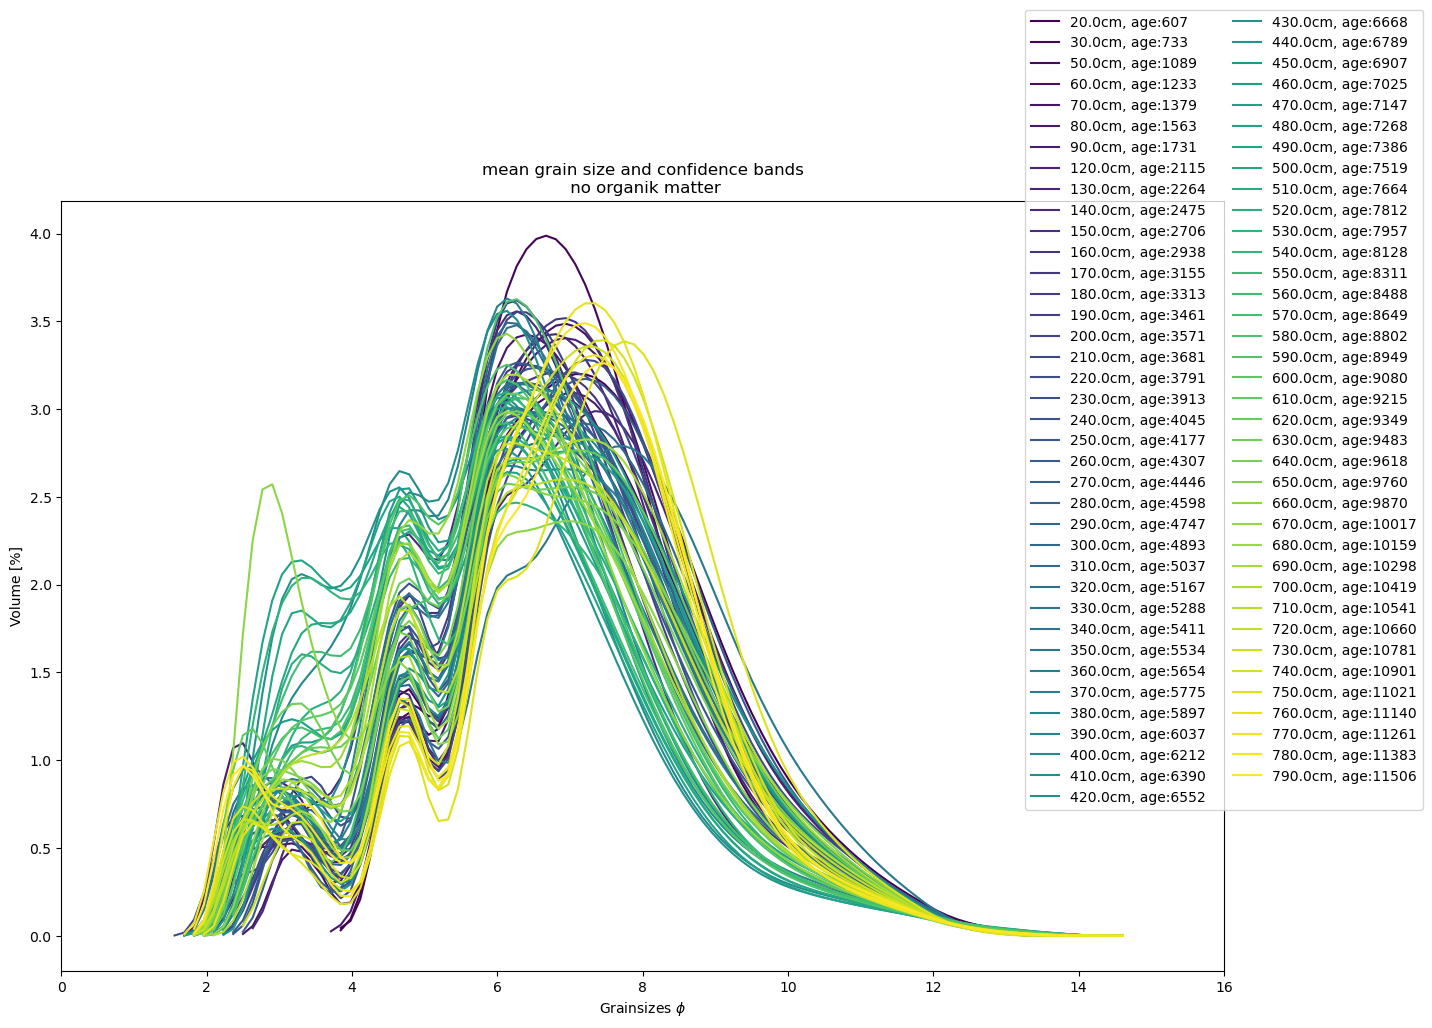

In [17]:
## convert back to % for sanity



n = len(pd.unique(grainsizes_summarize["depth"])) ## number of curves here
color = cm.viridis(np.linspace(0, 1, n)) 
fig, ax = plt.subplots(1,1, figsize=(15, 10))

for depth, c in zip(pd.unique(grainsizes_summarize["depth"]), color): # iterate over all depths and colors --> same lengths!
    plot_curve = grainsizes_summarize.loc[(grainsizes_summarize['depth'] == depth)]
    age = plot_curve["median"].iloc[0]
    plt.plot(plot_curve["gs_phi"], comp.clr_inv(plot_curve["Vol_clr_mean"])*100, label = f"{depth}cm, age:{age}", color = c ) # interim_ali["Vol_perc_clr"]
    # Add confidence bands
    # plt.fill_between(plot_curve["gs_phi"], 
    #                  comp.clr_inv((plot_curve["Vol_clr_mean"]-plot_curve["Vol_clr_std"]))*100, 
    #                  comp.clr_inv((plot_curve["Vol_clr_mean"]+plot_curve["Vol_clr_std"]))*100, 
    #                  color=c, alpha=.1)
    plt.legend(loc='lower center', ncol=2, bbox_to_anchor=(1, 0.2))

plt.title('mean grain size and confidence bands\n no organik matter')
plt.xlabel('Grainsizes $\phi$')
plt.ylabel('Volume [%]')
plt.xlim(0,16)
plt.show()

#### Plotting erster Anstieg:

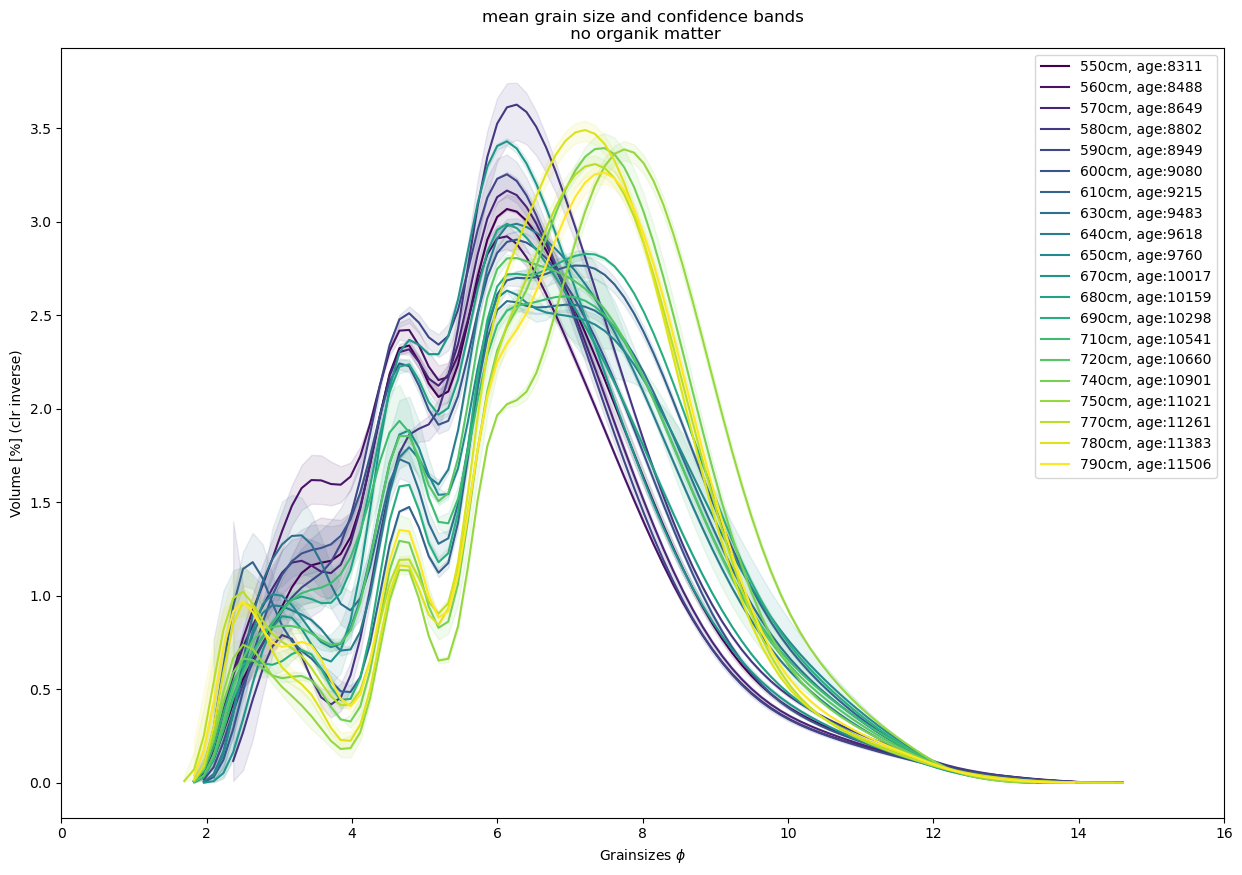

In [18]:
## convert back to % for sanity
desired_gs = [550,560,570,580,590,600,610, 630, 640, 650,670, 680,690,710, 720,740, 750,770, 780,790]


n = len(desired_gs) ## number of curves here
color = cm.viridis(np.linspace(0, 1, n)) 
fig, ax = plt.subplots(1,1, figsize=(15, 10))

for depth, c in zip(desired_gs, color): # iterate over all depths and colors --> same lengths!
    plot_curve = grainsizes_summarize.loc[(grainsizes_summarize['depth'] == depth)]
    age = plot_curve["median"].iloc[0]
    plt.plot(plot_curve["gs_phi"], comp.clr_inv(plot_curve["Vol_clr_mean"])*100, label = f"{depth}cm, age:{age}", color = c ) # interim_ali["Vol_perc_clr"]
    # Add confidence bands
    plt.fill_between(plot_curve["gs_phi"], 
                     comp.clr_inv((plot_curve["Vol_clr_mean"]-plot_curve["Vol_clr_std"]))*100, 
                     comp.clr_inv((plot_curve["Vol_clr_mean"]+plot_curve["Vol_clr_std"]))*100, 
                     color=c, alpha=.1)
    plt.legend()

plt.title('mean grain size and confidence bands\n no organik matter')
plt.xlabel('Grainsizes $\phi$')
plt.ylabel('Volume [%] (clr inverse)')
plt.xlim(0,16)
plt.show()

#### Plotting erster Abfall

In [19]:
pd.unique(grainsizes_summarize["depth"])


array([ 20.,  30.,  50.,  60.,  70.,  80.,  90., 120., 130., 140., 150.,
       160., 170., 180., 190., 200., 210., 220., 230., 240., 250., 260.,
       270., 280., 290., 300., 310., 320., 330., 340., 350., 360., 370.,
       380., 390., 400., 410., 420., 430., 440., 450., 460., 470., 480.,
       490., 500., 510., 520., 530., 540., 550., 560., 570., 580., 590.,
       600., 610., 620., 630., 640., 650., 660., 670., 680., 690., 700.,
       710., 720., 730., 740., 750., 760., 770., 780., 790.])

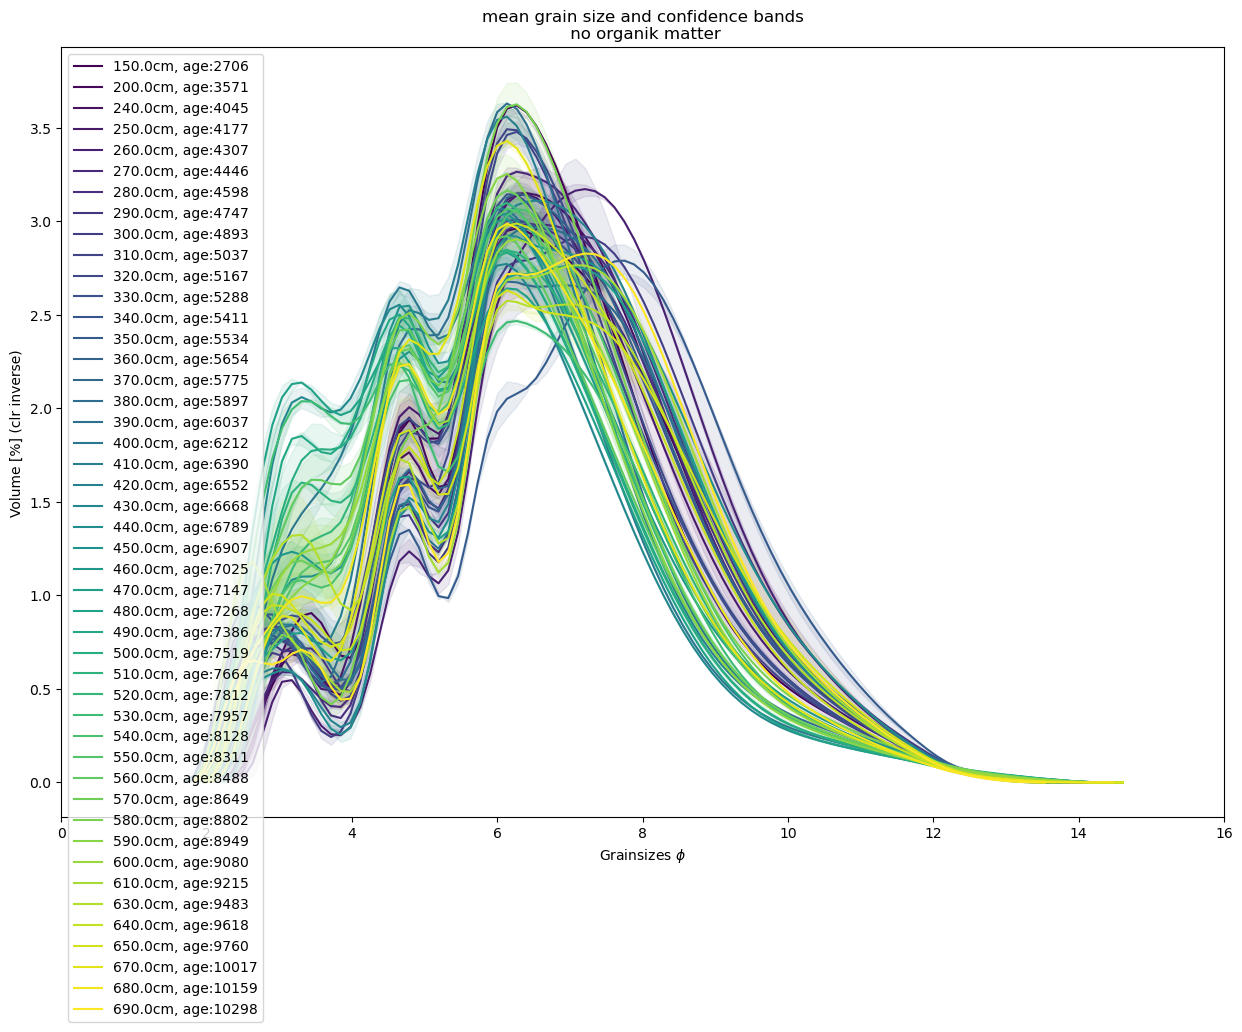

In [20]:
## convert back to % for sanity
#desired_gs = [330., 340., 350., 360., 370., 380., 390., 400., 410., 420., 430.,440., 450., 460., 470., 480., 490., 500., 510., 520., 530., 540.,550.]
desired_gs = [150., 200., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
       330., 340., 350., 360., 370., 380., 390., 400., 410., 420., 430.,
       440., 450., 460., 470., 480., 490., 500., 510., 520., 530., 540.,
       550., 560., 570., 580., 590., 600., 610., 630., 640., 650., 670.,
       680., 690.]

n = len(desired_gs) ## number of curves here
color = cm.viridis(np.linspace(0, 1, n)) 
fig, ax = plt.subplots(1,1, figsize=(15, 10))

for depth, c in zip(desired_gs, color): # iterate over all depths and colors --> same lengths!
    plot_curve = grainsizes_summarize.loc[(grainsizes_summarize['depth'] == depth)]
    age = plot_curve["median"].iloc[0]
    plt.plot(plot_curve["gs_phi"], comp.clr_inv(plot_curve["Vol_clr_mean"])*100, label = f"{depth}cm, age:{age}", color = c ) # interim_ali["Vol_perc_clr"]
    # Add confidence bands
    plt.fill_between(plot_curve["gs_phi"], 
                     comp.clr_inv((plot_curve["Vol_clr_mean"]-plot_curve["Vol_clr_std"]))*100, 
                     comp.clr_inv((plot_curve["Vol_clr_mean"]+plot_curve["Vol_clr_std"]))*100, 
                     color=c, alpha=.1)
    plt.legend()

plt.title('mean grain size and confidence bands\n no organik matter')
plt.xlabel('Grainsizes $\phi$')
plt.ylabel('Volume [%] (clr inverse)')
plt.xlim(0,16)
plt.show()

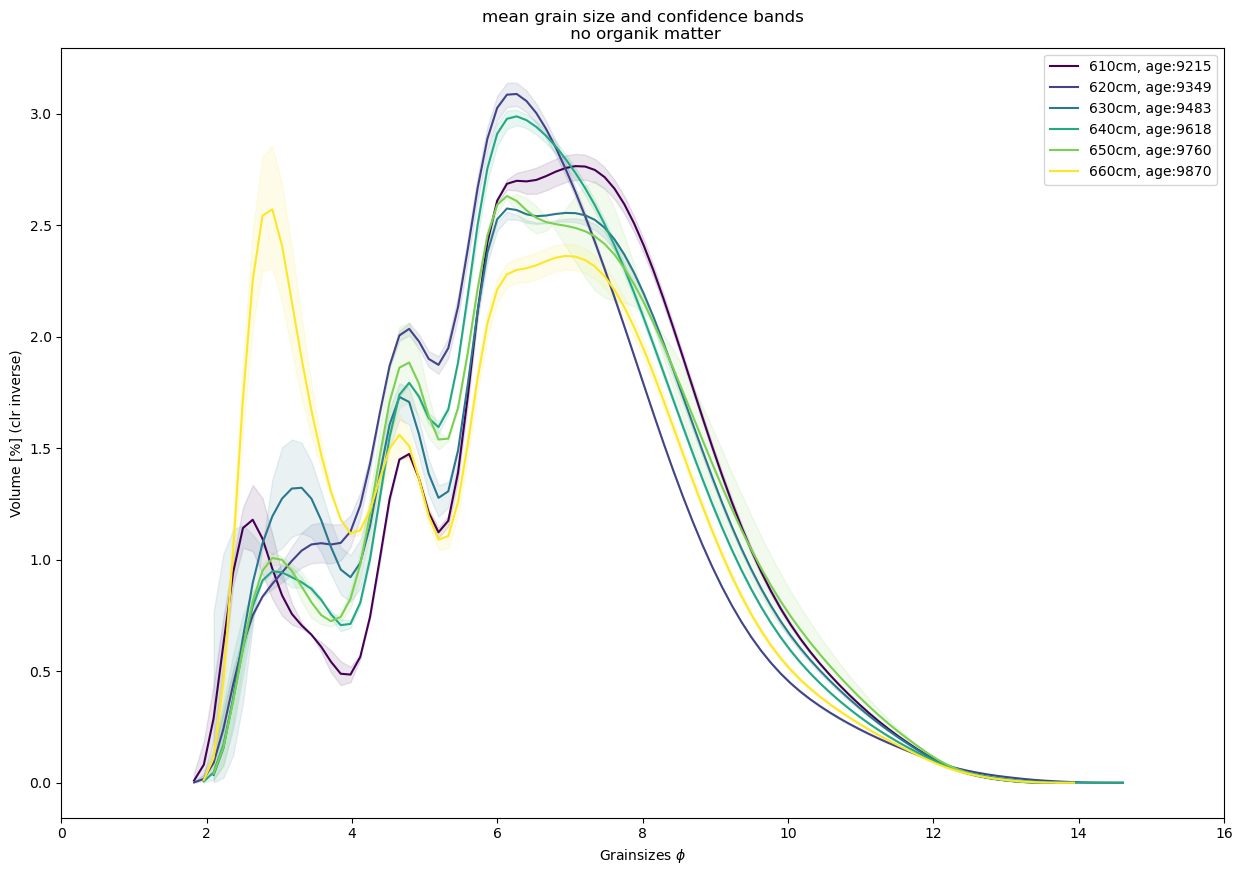

In [21]:
## convert back to % for sanity
#desired_gs = [330., 340., 350., 360., 370., 380., 390., 400., 410., 420., 430.,440., 450., 460., 470., 480., 490., 500., 510., 520., 530., 540.,550.]
desired_gs = [610, 620,630,640,650,660]#[20, 30, 60,70,80,90, 450,480, 610, 660]

n = len(desired_gs) ## number of curves here
color = cm.viridis(np.linspace(0, 1, n)) 
fig, ax = plt.subplots(1,1, figsize=(15, 10))

for depth, c in zip(desired_gs, color): # iterate over all depths and colors --> same lengths!
    plot_curve = grainsizes_summarize.loc[(grainsizes_summarize['depth'] == depth)]
    age = plot_curve["median"].iloc[0]
    plt.plot(plot_curve["gs_phi"], comp.clr_inv(plot_curve["Vol_clr_mean"])*100, label = f"{depth}cm, age:{age}", color = c ) # interim_ali["Vol_perc_clr"]
    # Add confidence bands
    plt.fill_between(plot_curve["gs_phi"], 
                     comp.clr_inv((plot_curve["Vol_clr_mean"]-plot_curve["Vol_clr_std"]))*100, 
                     comp.clr_inv((plot_curve["Vol_clr_mean"]+plot_curve["Vol_clr_std"]))*100, 
                     color=c, alpha=.1)
    plt.legend()

plt.title('mean grain size and confidence bands\n no organik matter')
plt.xlabel('Grainsizes $\phi$')
plt.ylabel('Volume [%] (clr inverse)')
plt.xlim(0,16)
plt.show()

In [22]:
## test for constant sum

## convert back to % for sanity
desired_gs = [380]


n = len(desired_gs) ## number of curves here
color = cm.viridis(np.linspace(0, 1, n)) 
#fig, ax = plt.subplots(1,1, figsize=(15, 10))

for depth, c in zip(desired_gs, color): # iterate over all depths and colors --> same lengths!
    plot_curve = grainsizes_summarize.loc[(grainsizes_summarize['depth'] == depth)]

#np.sum(comp.clr_inv(plot_curve["Vol_clr_mean"]))
plot_curve

,Vol_%,Kanaldurchmesser_unten_um,depth,acid,min,max,median,mean,gs_phi,Vol_clr_mean,Vol_clr_median,Vol_clr_std
2943,0.000158,0.040000,380.0,HNO3,5673,6152,5897,5903,14.609640,-7.327732,-7.322552,0.338164
2944,0.000214,0.043910,380.0,HNO3,5673,6152,5897,5903,14.475075,-7.045721,-7.047014,0.304576
2945,0.000358,0.048203,380.0,HNO3,5673,6152,5897,5903,14.340509,-6.550120,-6.547185,0.260342
2946,0.000717,0.052916,380.0,HNO3,5673,6152,5897,5903,14.205942,-5.866472,-5.860429,0.240188
2947,0.001482,0.058089,380.0,HNO3,5673,6152,5897,5903,14.071378,-5.136816,-5.131772,0.246883
...,...,...,...,...,...,...,...,...,...,...,...,...
3031,0.850405,146.824000,380.0,HNO3,5673,6152,5897,5903,2.767840,0.598856,0.601420,0.256510
3032,0.645956,161.177000,380.0,HNO3,5673,6152,5897,5903,2.633282,0.277107,0.541868,0.518723
3033,0.385475,176.935000,380.0,HNO3,5673,6152,5897,5903,2.498709,-0.212308,0.298697,1.082912
3034,0.165453,194.232000,380.0,HNO3,5673,6152,5897,5903,2.364147,-0.987539,-0.176706,2.011700
